In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:

def add_indicators(df):
    # 20-day moving average
    df['MA20'] = df['adj_close'].rolling(window=20).mean()
    # RSI
    delta = df['adj_close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    # MACD
    exp1 = df['adj_close'].ewm(span=12, adjust=False).mean()
    exp2 = df['adj_close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    return df

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000, commission_fee=0.01, slippage_cost=0.1):
        super(StockTradingEnv, self).__init__()
        self.data = add_indicators(data)
        self.current_step = 0
        self.initial_balance = initial_balance
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.date = data['date']
        self.stock_price_history = data['adj_close']
        self.commission_fee = commission_fee
        self.slippage_cost = slippage_cost
        
        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), shape=(2,))  # (Action, Amount) where Action: -1: Buy, 0: Hold, 1: Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,))
        
        self.render_df = pd.DataFrame()
        self.done = False
        self.current_portfolio_value = initial_balance
      
    def reset(self, seed = None):
        self.current_step = 0
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.done = False
        self.current_portfolio_value = self.initial_balance
        return self._get_observation(), {}
    
    def step(self, action):
        assert self.action_space.contains(action)
        prev_portfolio_value = self.balance if self.current_step == 0 else self.balance + self.stock_owned * self.stock_price_history[self.current_step - 1]
        current_price = self.stock_price_history[self.current_step]    
        amount = int(self.initial_balance * action[1] / current_price)
    
        if action[0] > 0:  # Buy
            amount =  min( int(self.initial_balance * action[1] / current_price), int(self.balance / current_price * (1 + self.commission_fee + self.slippage_cost)))
            if self.balance >= current_price * amount * (1 + self.commission_fee + self.slippage_cost):
                self.stock_owned += amount
                self.balance -= current_price * amount * (1 + self.commission_fee + self.slippage_cost)
        elif action[0] < 0:  # Sell
            amount = min(amount, self.stock_owned)
            if self.stock_owned > 0:
                self.stock_owned -= amount
                self.balance += current_price * amount * (1 - self.commission_fee - self.slippage_cost)
        
        current_portfolio_value = self.balance + self.stock_owned * current_price
        excess_return = current_portfolio_value - prev_portfolio_value 
        risk_free_rate = 0.02  # Example risk-free rate
        std_deviation = np.std(self.stock_price_history[:self.current_step + 1])
        sharpe_ratio = (excess_return - risk_free_rate) / std_deviation if std_deviation != 0 else 0
        reward = sharpe_ratio
         
        self.render(action, amount, current_portfolio_value)
        obs = self._get_observation()
        
        self.current_step += 1
        
        if self.current_step == len(self.data['adj_close']):
            done = True
        else:
            done = False
        
        self.done = done

        info = {}  
        return obs, reward, done, False,info
    
    def _get_observation(self):
        return np.array([
            self.stock_price_history[self.current_step]
        ])
    
    def render(self, action, amount, current_portfolio_value, mode = None):
        current_date = self.date[self.current_step]
        today_action =  'buy' if action[0] > 0 else 'sell'
        current_price = self.stock_price_history[self.current_step]
        
        if mode == 'human':
            print(f"Step:{self.current_step}, Date: {current_date}, Market Value: {current_portfolio_value:.2f}, Balance: {self.balance:.2f}, Stock Owned: {self.stock_owned}, Stock Price: {current_price:.2f}, Today Action: {today_action}:{amount}")
        else:
            pass
        dict = {
            'Date': [current_date], 'market_value': [current_portfolio_value], 'balance': [self.balance], 'stock_owned': [self.stock_owned], 'price': [current_price], 'action': [today_action], 'amount':[amount]
        }
        step_df = pd.DataFrame.from_dict(dict)
        self.render_df = pd.concat([self.render_df, step_df], ignore_index=True)

    def render_all(self):
        df = self.render_df.set_index('Date')       
        fig, ax = plt.subplots(figsize=(18, 6)) 
        df.plot( y="market_value" , use_index=True,  ax = ax, style='--' , color='lightgrey') 
        df.plot( y="price" , use_index=True,  ax = ax , secondary_y = True , color='black')
         
        for idx in df.index.tolist():
            if (df.loc[idx]['action'] == 'buy') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] - 1,
                    'g^'
                )
                plt.text(idx, df.loc[idx]["price"]- 3, df.loc[idx]['amount'] , c= 'green',fontsize=8, horizontalalignment='center', verticalalignment='center')
            elif (df.loc[idx]['action'] == 'sell') & (df.loc[idx]['amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] + 1,
                    'rv'
                    )
                plt.text(idx, df.loc[idx]["price"] + 3, df.loc[idx]['amount'], c= 'red',fontsize=8, horizontalalignment='center', verticalalignment='center')

In [3]:
from pybroker import YFinance
import pybroker
pybroker.enable_data_source_cache('yfinance')
from stable_baselines3 import PPO

In [37]:
yfinance = YFinance()
ticker = 'IBM'
dftrain = yfinance.query([ticker], start_date='1/1/2011', end_date='1/1/2023')
dftrain['date'] = pd.to_datetime(dftrain['date']).dt.date
dftrain.drop('symbol', axis=1, inplace=True)
dftrain

Loaded cached bar data.



,date,open,high,low,close,volume,adj_close
0,2011-01-03,140.736145,141.682602,140.669220,140.994263,4815575,84.841385
1,2011-01-04,141.070740,141.701721,140.191208,141.147232,5292865,84.933441
2,2011-01-05,140.860428,140.994263,140.277252,140.583176,4871640,84.594048
3,2011-01-06,140.659653,142.246658,140.363297,142.122375,5260543,85.520210
4,2011-01-07,142.246658,142.313583,140.478012,141.424469,4325942,85.100288
...,...,...,...,...,...,...,...
3015,2022-12-23,140.589996,141.860001,139.600006,141.649994,2092500,130.239639
3016,2022-12-27,141.729996,142.720001,141.229996,142.419998,2742400,130.947617
3017,2022-12-28,142.399994,142.809998,139.949997,140.020004,2539500,128.740952
3018,2022-12-29,140.580002,142.259995,140.449997,141.059998,2337200,129.697174


C:\Users\Yatharth Jain\AppData\Local\Temp\ipykernel_18020\3561315092.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


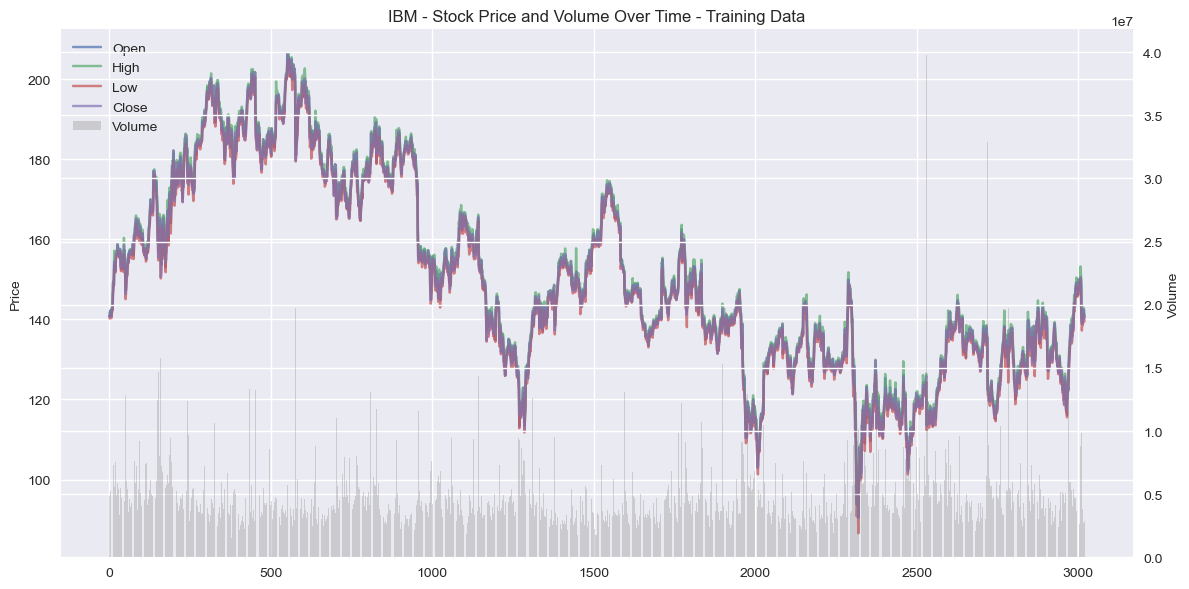

In [38]:
import seaborn as sns

# Set style
plt.style.use('seaborn')

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot OHLC on primary axis
ax1.plot(dftrain.index, dftrain['open'], label='Open', alpha=0.7)
ax1.plot(dftrain.index, dftrain['high'], label='High', alpha=0.7)
ax1.plot(dftrain.index, dftrain['low'], label='Low', alpha=0.7)
ax1.plot(dftrain.index, dftrain['close'], label='Close', alpha=0.7)
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create secondary axis for volume
ax2 = ax1.twinx()
ax2.bar(dftrain.index, dftrain['volume'], alpha=0.3, color='gray', label='Volume')
ax2.set_ylabel('Volume')

# Format
plt.title(ticker + ' - Stock Price and Volume Over Time - Training Data')
plt.xticks(rotation=45)

# Show both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [39]:
env = StockTradingEnv(dftrain, initial_balance=100000, commission_fee=0.0001, slippage_cost=0.005)
modelname = "ppo_"+ticker

tr = input("Train the model? (y/n): ")

if tr == 'y':
    model = PPO(
        "MlpPolicy", 
        env,
        learning_rate=1e-4,
        batch_size=256,
        n_steps=2048,
        gamma=0.99,
        gae_lambda=0.95,
        n_epochs=10,
        ent_coef=0.01,
        policy_kwargs=dict(
            net_arch=[dict(pi=[128, 128], vf=[128, 128])]
        ),
        verbose=0
    )
    model.learn(total_timesteps=100_000, progress_bar=True)
    # model.save(modelname)
    model.save(os.path.join('models', modelname))

In [40]:
yfinance = YFinance()
dftest = yfinance.query([ticker], start_date='1/1/2023', end_date='1/1/2024')
dftest['date'] = pd.to_datetime(dftest['date']).dt.date
dftest.drop('symbol', axis=1, inplace=True)
dftest


Loaded cached bar data.



,date,open,high,low,close,volume,adj_close
0,2023-01-03,141.100006,141.899994,140.479996,141.550003,3338600,130.147690
1,2023-01-04,142.070007,143.619995,141.369995,142.600006,3869200,131.113129
2,2023-01-05,142.440002,142.500000,140.009995,141.110001,2866600,129.743118
3,2023-01-06,142.380005,144.250000,141.580002,143.699997,3574000,132.124512
4,2023-01-09,144.080002,145.470001,143.399994,143.550003,3987700,131.986588
...,...,...,...,...,...,...,...
245,2023-12-22,161.100006,162.410004,161.000000,162.139999,2439800,156.483139
246,2023-12-26,162.229996,163.309998,162.050003,163.210007,1772400,157.515808
247,2023-12-27,163.139999,163.639999,162.679993,163.460007,3234600,157.757095
248,2023-12-28,163.960007,163.960007,163.399994,163.750000,2071300,158.036957


C:\Users\Yatharth Jain\AppData\Local\Temp\ipykernel_18020\970189511.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


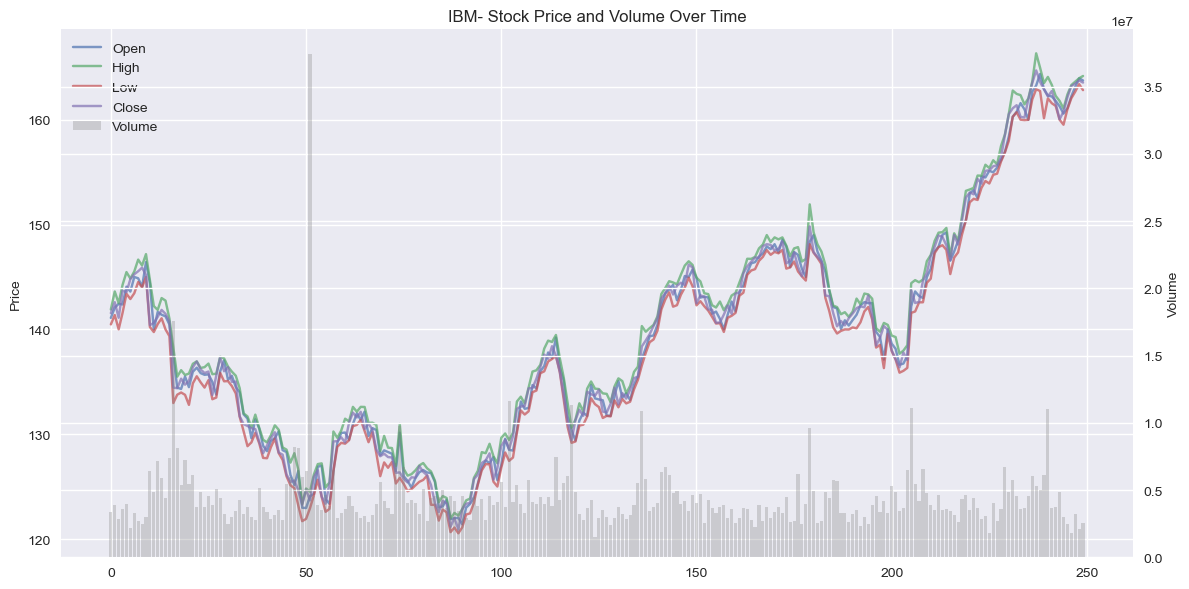

In [41]:
# Set style
plt.style.use('seaborn')

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot OHLC on primary axis
ax1.plot(dftest.index, dftest['open'], label='Open', alpha=0.7)
ax1.plot(dftest.index, dftest['high'], label='High', alpha=0.7)
ax1.plot(dftest.index, dftest['low'], label='Low', alpha=0.7)
ax1.plot(dftest.index, dftest['close'], label='Close', alpha=0.7)
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')

# Create secondary axis for volume
ax2 = ax1.twinx()
ax2.bar(dftest.index, dftest['volume'], alpha=0.3, color='gray', label='Volume')
ax2.set_ylabel('Volume')

# Format
plt.title(ticker + '- Stock Price and Volume Over Time')
plt.xticks(rotation=45)

# Show both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

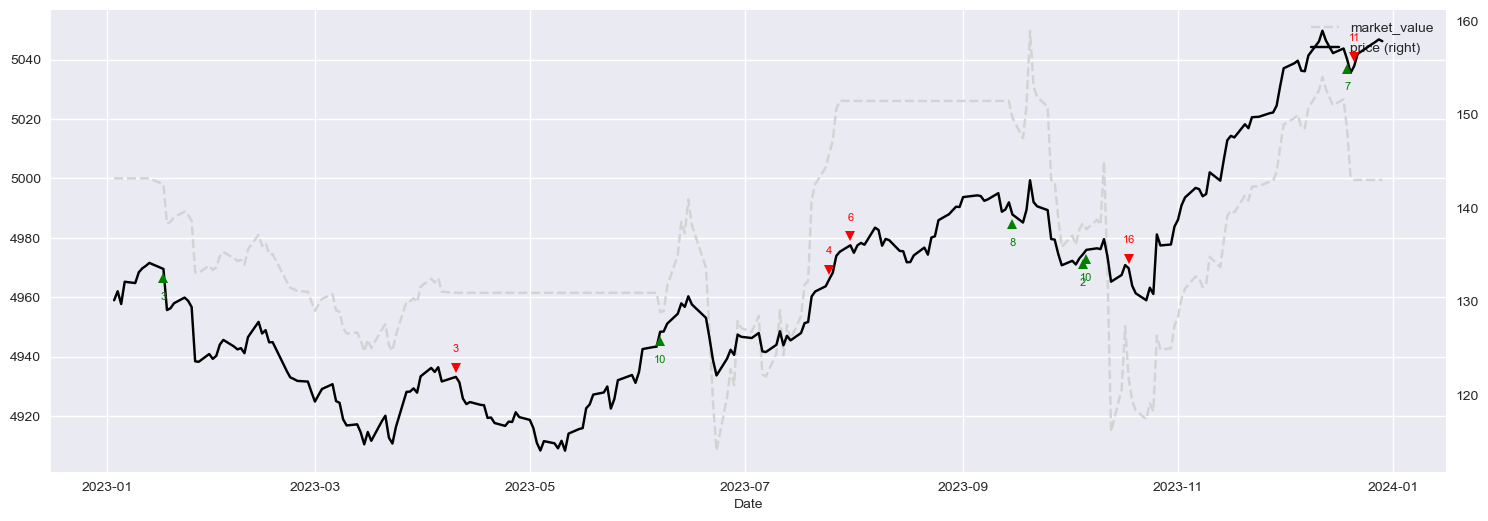

In [84]:
env = StockTradingEnv(dftest, initial_balance=5000, commission_fee=0.0001, slippage_cost=0.005)

model = PPO.load(os.path.join('models', modelname), env=env)

vec_env = model.get_env()
obs = vec_env.reset()
for i in range(len(dftest['adj_close'])):
    action, _state = model.predict(obs)
    obs, reward, done, info = vec_env.step(action)

env.render_all()

In [85]:
def calculate_accuracy(env, lookahead_steps=20):
    profitable_trades = 0
    total_trades = 0
    render_df = env.render_df.reset_index()  # Reset the index for safe access
    
    for idx in range(len(render_df) - lookahead_steps):  # Stop at the second-to-last index
        action = render_df.loc[idx]['action']
        if action in ['buy', 'sell']:
            total_trades += 1
            initial_price = render_df.loc[idx]['price']
            future_prices = render_df.loc[idx + 1:idx + lookahead_steps]['price']
            
            if action == 'buy':
                if any(future_prices > initial_price):
                    profitable_trades += 1
            elif action == 'sell':
                if any(future_prices < initial_price):
                    profitable_trades += 1
    
    return profitable_trades / total_trades if total_trades > 0 else 0

In [86]:
def calculate_roi(env):
    final_portfolio_value = env.render_df['market_value'].iloc[-1]
    initial_balance = env.initial_balance
    return ((final_portfolio_value - initial_balance) / initial_balance) * 100


In [87]:
def calculate_sharpe_ratio(env):
    # Get daily returns from portfolio values
    sharpe_ratio = 1
    portfolio_values = env.render_df['market_value']
    daily_returns = portfolio_values.pct_change().dropna()
    
    # Calculate average daily return and standard deviation
    avg_daily_return = daily_returns.mean()
    daily_std = daily_returns.std()
    
    # Assume risk-free rate of 2% annually, convert to daily
    risk_free_rate = 0.02 / 252  # 252 trading days in a year
    
    # Calculate annualized Sharpe ratio 
    sharpe_ratio += ((np.sqrt(252) * (avg_daily_return - risk_free_rate))) / daily_std
    
    return sharpe_ratio

In [88]:
print (modelname)

accuracy = calculate_accuracy(env)
print(f"Accuracy: {accuracy:.2%}")

roi = calculate_roi(env)
print(f"ROI: {roi:.2f}%")

sharpe = calculate_sharpe_ratio(env)
print(f"Sharpe Ratio: {sharpe:.2f}")

pd.DataFrame([[modelname, accuracy, roi, sharpe]], columns=['Model', 'Accuracy', 'ROI', 'Sharpe Ratio']).to_csv(os.path.join('eval', ticker+'eval.csv'), mode='a', header=False, index=False)


ppo_IBM
Accuracy: 79.57%
ROI: -0.01%
Sharpe Ratio: 0.23


In [89]:
import csv

env.render_df.to_csv(os.path.join('eval', ticker+'_trading_results.csv'), index=False)
